In [1]:
import polars as pl

In [2]:
parquet_path = "../../test_result.parquet/*"

In [3]:
fuel_type_edf = (
    pl.scan_parquet(parquet_path)
    .filter(pl.col("test_result") == "P")
    .with_columns(
        pl.col("fuel_type")
        .replace({"Hybrid Electric (Clean)": "HY", "Electric": "EL"},
                 default=pl.first())
        .cast(str),
        pl.col("test_date").dt.year().alias("Year"),
    )
    .group_by(["Year", "fuel_type"])
    .agg(pl.col("test_result").count().alias("vehicle_count"))
    .collect(streaming=True) # streaming required to prevent OOM
)

In [4]:
fuel_type_ldf = (
    pl.scan_parquet(parquet_path)
    .select(["test_result", "test_date", "fuel_type"])
    .filter(pl.col("test_result") == "P")
    .with_columns(
        pl.col("fuel_type")
        .replace({"Hybrid Electric (Clean)": "HY", "Electric": "EL"},
                 default=pl.first())
        .cast(str),
        pl.col("test_date").dt.year().alias("Year"),
    )
    .group_by(["Year", "fuel_type"])
    .agg(pl.col("test_result").count().alias("vehicle_count"))
)

In [5]:
print(fuel_type_ldf.explain())

AGGREGATE
	[col("test_result").count().alias("vehicle_count")] BY [col("Year"), col("fuel_type")] FROM
   WITH_COLUMNS:
   [col("fuel_type").python_udf().strict_cast(Utf8), col("test_date").dt.year().alias("Year")]
    FAST_PROJECT: [test_result, test_date, fuel_type]

        Parquet SCAN 854 files: first file: ../../test_result.parquet/part.0.parquet
        PROJECT 3/14 COLUMNS
        SELECTION: [(col("test_result")) == (Utf8(P))]


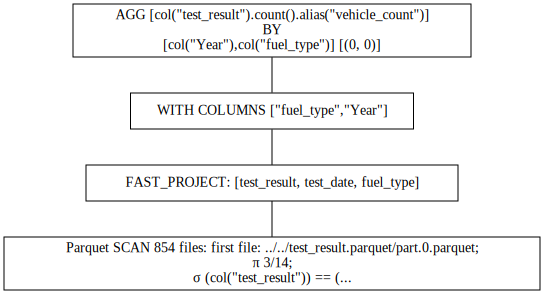

In [6]:
fuel_type_ldf.show_graph()

In [7]:
fuel_type_df = (
    fuel_type_edf.pivot(
        index="Year",
        columns="fuel_type",
        values="vehicle_count",
        aggregate_function="sum",
        sort_columns=True,
    )
    .fill_null(0)
    .sort(by="Year")
    .to_pandas()
    .set_index("Year")
)

fuel_type_df.head()

,CN,DI,ED,EL,FC,GA,GB,GD,HY,LN,LP,OT,PE,ST
Year,,,,,,,,,,,,,,
2005,11,1258805,0,335,3,20,121,0,25,18,7030,125,4098561,26
2006,61,5438952,0,1699,20,50,481,1,152,53,31308,693,17368825,89
2007,54,5973332,0,2539,36,56,584,1,381,66,32428,1159,17411739,104
2008,56,6448408,0,4660,85,54,682,2,1129,65,32569,2367,17174571,110
2009,58,7008115,0,7980,133,57,733,3,2424,68,31810,4276,17086268,122


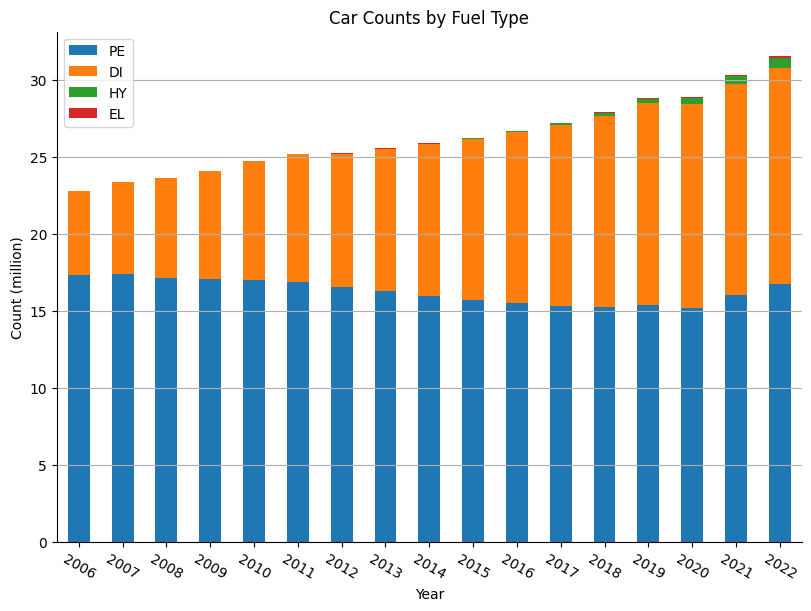

In [8]:
import matplotlib.pyplot as plt
from simpler_mpl import set_commas, set_common_mpl_styles

fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 6))

fuel_type_df.loc[2006:, ["PE", "DI", "HY", "EL"]].div(1000000).reset_index().plot.bar(
    x="Year", stacked=True, title="Car Counts by Fuel Type", ax=ax
)

ax.set_ylabel("Count (million)")
set_common_mpl_styles(ax=ax)
plt.xticks(rotation=-30);